In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## for our scripts:
# %aimport hmm
%autoreload 2
import hmm
## for plotting
%matplotlib inline

In [3]:
data_dir = os.path.join('.','data')

ref = pd.read_excel(os.path.join(data_dir, 'GroundTruths.xlsx'), 
                    names=['file', 'date_time'])
ref.date_time = pd.to_datetime(ref.date_time)

# df = pd.read_csv(os.path.join(data_dir, 'data_6302.csv'), index_col=0)

In [4]:
if not os.path.isfile(os.path.join(data_dir, 'completeDB.h5')):
    print('reading in...')
    df = pd.concat([pd.read_csv(os.path.join(data_dir, 'data_6302.csv'), 
                                 index_col=0, parse_dates=True),
                    pd.read_csv(os.path.join(data_dir, 'data_7600.csv'), 
                                 index_col=0, parse_dates=True),
                    pd.read_csv(os.path.join(data_dir, 'data_7664.csv'), 
                                 index_col=0, parse_dates=True)])
    print('creating h5...')
    df.to_hdf(os.path.join(data_dir, 'completeDB.h5'))
    print('done!')
else:
    print('reading h5...')
    df = pd.read_hdf(os.path.join(data_dir, 'completeDB.h5'))
    print('done!')

reading h5...
done!


In [5]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_n = scale.fit_transform(df.loc[:,'T_1':'T_27'].values)
df_n = pd.DataFrame(data=df_n, index=df.index, columns=df.loc[:,'T_1':'T_27'].columns)

# dfo = df_n[df_n.abs()<3]
# dfo.index = pd.to_datetime(dfo.index)
compress_window = '3h'
dfr = df_n.resample(compress_window).median()
dfr = dfr[dfr.abs()<3]

dfr = dfr.dropna()

In [6]:


target = pd.Series(index=df_n.index, data=0)
target[np.isin(df_n.index,ref.date_time)] = 1

# dfr = dfo.resample(compress_window).mean()
target = target.resample(compress_window).max()
target = target[dfr.index]

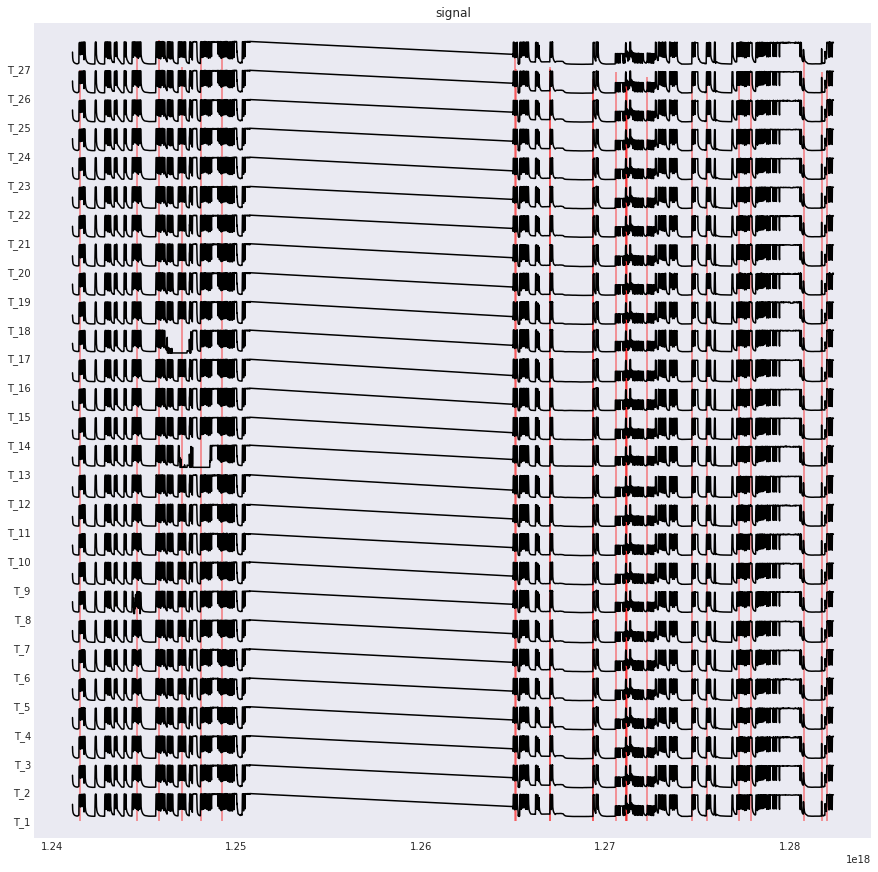

In [13]:
with sns.axes_style('dark'):
    plt.figure(figsize=(15,15))
    
#     for i, (name, sig) in enumerate(dfr.loc[:,'T_1':].iteritems()):
#         plt.plot(dfr.loc[:,'T_1':].mean(axis=1) - sig+0.1*i, 'k')
#     plt.vlines(ref[ref.file==6302].date_time.values, 0, 2.6, color='r', alpha=.5)
#     plt.title('signal deviation from mean')
#     plt.yticks(np.arange(0,2.8, .1),dfr.loc[:,'T_1':].columns )
    
    for i, (name, sig) in enumerate(dfr.iteritems()):
        plt.plot(sig+dfr.max().max()*i, 'k')
    plt.vlines(ref.date_time.values, 0, 27*dfr.max(), color='r', alpha=.5)
    plt.title('signal')
    plt.yticks(np.arange(0,27*dfr.max().max(), dfr.max().max()),dfr.columns )
    plt.ylim(-.1, 27*dfr.max().max()+.1)

In [21]:
mod = hmm.RollingHMM(dfr.T_3, 3, target, anomaly_window='6h')

In [23]:
mod.fit(n_jobs=3)

Parsing sub-sequences...
Parsed 4968 state sequences...
removed 4968 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
[1] Improvement: 1987.0969544074378	Time (s): 0.0303
[2] Improvement: 89.214340777693	Time (s): 0.02834
[3] Improvement: 34.440599830912106	Time (s): 0.03032
[4] Improvement: 16.091880366973783	Time (s): 0.03086
[5] Improvement: 7.507086428133334	Time (s): 0.02902
[6] Improvement: 3.6024055962989223	Time (s): 0.02846
[7] Improvement: 1.839077419568639	Time (s): 0.02744
[8] Improvement: 1.0023004125359876	Time (s): 0.03011
[9] Improvement: 0.5779437962919474	Time (s): 0.0304
[10] Improvement: 0.3488535405085713	Time (s): 0.03187
[11] Improvement: 0.21840893319858878	Time (s): 0.02689
[12] Improvement: 0.14079112653780612	Time (s): 0.02697
[13] Improvement: 0.0929115060444019	Time (s): 0.02996
[14] Improvement: 0.062491285119904205	Time (s): 0.02894
[15] Improvement: 0.04268888278238592	Time (s): 0.03821
[16] Improvement: 0.029536926513173967	Time (s)

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.03364355158200254,
                    0.005294434368431526
                ],
                "frozen" : false
            },
            "name" : "s0",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.1550295444964489,
                 

In [24]:
lprob = mod.like()

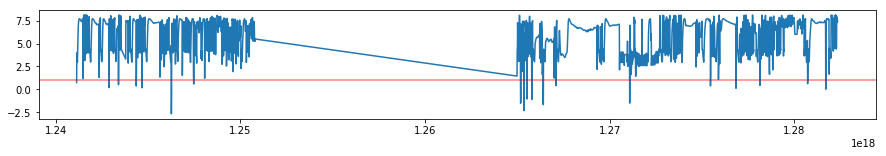

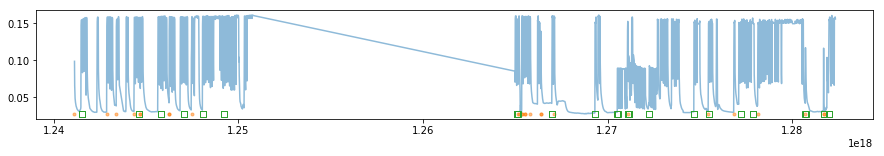

In [25]:
# lprob.plot()
# plt.vlines(ref[ref.file==6302].date_time.values, -10, 10, color='r', alpha=.5)
window_target = mod.target.rolling(mod.window).apply(np.max)

thres=1

plt.figure(figsize=(15,2))
plt.plot(lprob)
plt.axhline(thres, color='r', alpha=.5)

plt.figure(figsize=(15,2))
plt.plot(mod.s, alpha=.5)

plt.plot((mod.s.min()*mod.s/mod.s)[lprob<thres], '.', alpha=.5)
plt.plot(mod.s.min()*window_target[window_target==1], 's', markerfacecolor='none')
# plt.plot(mod.s[window_target==1], 's', markerfacecolor='none')

# dprob = pd.Series(np.gradient(lprob), index=lprob.index)
# plt.plot(dprob.iloc[10:])
# pd.to_datetime(ref[ref.file==6302].date_time)

In [47]:
experiment = {}

from tqdm import tqdm_notebook

for sensor, signal in tqdm_notebook(dfr.items()):
    experiment[sensor] = hmm.RollingHMM(signal, 3, target, anomaly_window='6h')
    experiment[sensor].fit(verbose=False, n_jobs=3)
    

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Trainin

In [57]:
res = {n:i.like() for n,i in experiment.items()}
rmse = {n:i.rmse() for n,i in experiment.items()}


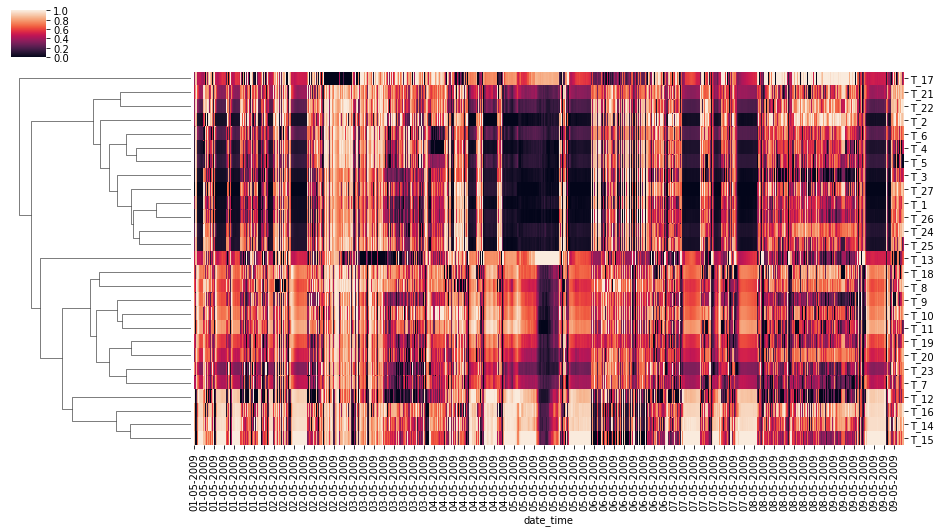

In [72]:
df = pd.DataFrame(data=res)
cg = sns.clustermap(df.T,
              col_cluster=False, standard_scale=1, figsize=(16,8))
cg.ax_heatmap.set_xticklabels(df.reset_index().date_time.dt.strftime('%d-%m-%Y'));

In [87]:
from scipy.stats import hmean
rmse_df = pd.Series(rmse).sort_values()
hmean(np.array(list(rmse.values())))
# mod.s.iloc[np.argpartition(mod.like(), 27)[:27]]
# int(mod.target.sum())

553.69011536722576

634.57911859554599

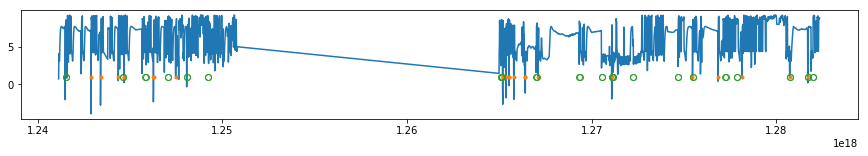

In [64]:
# norm = pd.Series( np.linalg.norm(res, axis=0), index=dfr.index)
plt.figure(figsize=(15,2))
plt.plot(norm)

from itertools import chain
import datetime as dt
norm = res['T_3']
min_idx = np.argpartition(norm, ref.shape[0])[:ref.shape[0]]
# min_idx = list(chain(*[np.argpartition(i, ref.shape[0])[:ref.shape[0]] for i in res]))
plt.plot((norm/norm).iloc[min_idx], '.')
plt.plot(window_target[window_target==1], 'o', markerfacecolor='none')
np.sqrt((np.array([i.item()*1e-13 for i in (norm.iloc[min_idx].sort_index().index.values -\
                          ref.sort_values(by='date_time').date_time.values)])**2).mean())

In [129]:
from sklearn.linear_model import SGDClassifier

resX = pd.DataFrame(index=dfr.index, data=res.T)
resX.shape

n_trials = 100
trials = np.empty((n_trials, 2))

for i in range(n_trials):
    clf = SGDClassifier(class_weight='balanced', 
                        max_iter=1000, tol=1e-3)
    clf_old = SGDClassifier(class_weight='balanced', 
                            max_iter=1000, tol=1e-3)

    clf.fit(resX.values[:2000], window_target.values[:2000])
    clf_old.fit(dfr.values[:2000], window_target.values[:2000])
    trials[i,0] = clf.score(resX.values[2000:], target[2000:])
    trials[i,1] = clf_old.score(dfr.values[2000:], target[2000:])

In [130]:
clf.score(resX.values[2000:], target[2000:]), clf_old.score(dfr.values[2000:], target[2000:])

(0.80165289256198347, 0.98966942148760328)

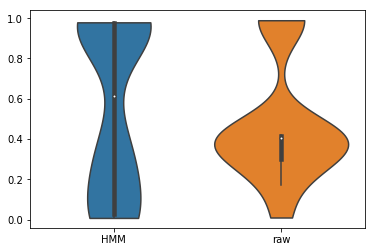

In [131]:
sns.violinplot(data=pd.DataFrame(trials, columns=['HMM', 'raw']), cut=0)

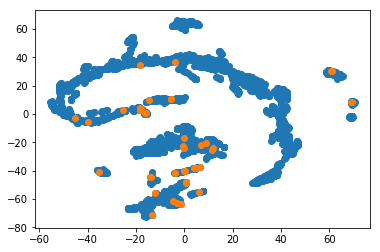

In [132]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE 
# pca = TruncatedSVD()
dfr_proj = TSNE().fit_transform(dfr)

plt.scatter(dfr_proj[:,0], dfr_proj[:,1])
plt.scatter(dfr_proj[window_target==1][:,0], dfr_proj[window_target==1][:,1])

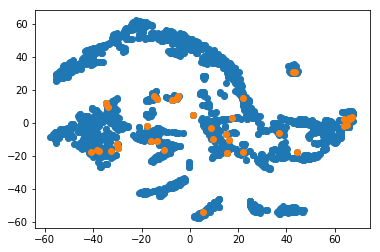

In [133]:
resX_proj = TSNE().fit_transform(resX)
plt.scatter(resX_proj[:,0], resX_proj[:,1])
plt.scatter(resX_proj[window_target==1][:,0], resX_proj[window_target==1][:,1])

In [89]:
%run hmm.py